<a href="https://colab.research.google.com/github/sanAkel/ufs_diurnal_diagnostics/blob/main/RTOFS/AWS_download/rtofs_sHem_sea_ice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install cartopy
!pip install copernicusmarine

In [ ]:
import copernicusmarine

import xarray as xr
import numpy as np
import pandas as pd
from datetime import datetime

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

In [ ]:
def get_cmems_data(dsetID, vNames, lon_start, lon_end, lat_start, lat_end, time_start, time_end):

  data_request = {"dataset_id" : dsetID,
    "longitude" : [lon_start, lon_end],
    "latitude" : [lat_start, lat_end],
    "time" : [time_start, time_end],
    "variables" : vNames}

  cms_data =copernicusmarine.open_dataset(
    dataset_id = data_request["dataset_id"],
    minimum_longitude = data_request["longitude"][0],
    maximum_longitude = data_request["longitude"][1],
    minimum_latitude = data_request["latitude"][0],
    maximum_latitude = data_request["latitude"][1],
    start_datetime = data_request["time"][0],
    end_datetime = data_request["time"][1],
    variables = data_request["variables"])

  return cms_data

In [ ]:
def plot_subplot(figh, iPlot, ds, lon_name, lat_name, plot_title, nPlots=3):

  ax = figh.add_subplot(1,nPlots,iPlot, projection=ccrs.PlateCarree(central_longitude=0.0))
  ax.coastlines(color='k', alpha=0.9)
  ax.add_feature(cfeature.LAND, zorder=10, edgecolor='k', alpha=0.9)

  im = ds.plot(ax=ax, x=lon_name, y=lat_name, vmin=0, vmax=1, cmap='gist_ncar',
               transform=ccrs.PlateCarree(),
               add_labels=False, add_colorbar=False)

  cax = ax.inset_axes([1.01, 0.01, 0.01, 1.5])
  figh.colorbar(im, cax=cax, orientation='vertical', ticks=np.arange(0., 1.1, 0.1))
  cax.tick_params(labelsize=4, rotation=0)

  ax.set_title(plot_title, fontsize=6)
  ax.set_extent([-180, 180, -40, -90], ccrs.PlateCarree())

  gl = ax.gridlines(draw_labels=True)
  gl.top_labels = False
  gl.right_labels = False
  gl.xformatter = LONGITUDE_FORMATTER
  gl.yformatter = LATITUDE_FORMATTER
  gl.xlabel_style = {'size': 4}
  gl.ylabel_style = {'size': 4}

In [ ]:
# OSTIA SST and Sea Ice Conc
sst={'dsetID':'METOFFICE-GLO-SST-L4-NRT-OBS-SST-V2',
     'vNames':['analysed_sst'],
     'varName': 'SST'}

iceCov={'dsetID': 'METOFFICE-GLO-SST-L4-NRT-OBS-SST-V2',
        'vNames': ['sea_ice_fraction'],
        'varName': 'Sea Ice Concentration'}

In [ ]:
# Set Copernicus credentials
CMEMS_username, CMEMS_passwd = ["sakella", "HbFPyP9M"]
copernicusmarine.login(username=CMEMS_username, password=CMEMS_passwd)

In [ ]:
lon_bounds = [-180, 180]
lat_bounds = [-90, -40]
date_bounds = [datetime(2025, 5, 7), datetime(2025, 5, 10)]

In [ ]:
# OSTIA sea ice concentration

#ostia_sst = get_cmems_data(sst['dsetID'], sst['vNames'],
#                        lon_bounds[0], lon_bounds[1],
#                        lat_bounds[0], lat_bounds[1],
#                        date_bounds[0].strftime('%Y-%m-%d'),
#                        date_bounds[1].strftime('%Y-%m-%d'))

ostia_ice = get_cmems_data(iceCov['dsetID'], iceCov['vNames'],
                           lon_bounds[0], lon_bounds[1],
                           lat_bounds[0], lat_bounds[1],
                           date_bounds[0].strftime('%Y-%m-%d'),
                           date_bounds[1].strftime('%Y-%m-%d'))

# save to local file instead of cloud data access/plot- which is SLOW!
ostia_ice.to_netcdf('ostia_ice.nc')
ds_ostia_ice = xr.open_dataset('ostia_ice.nc')

In [ ]:
# RTOFS (ice concentration)

url_base = 'https://noaa-nws-rtofs-pds.s3.amazonaws.com/rtofs.'

fName = 'rtofs_glo_2ds_n000_ice.nc'
HR = '00' # 0 UTC -- "n000"

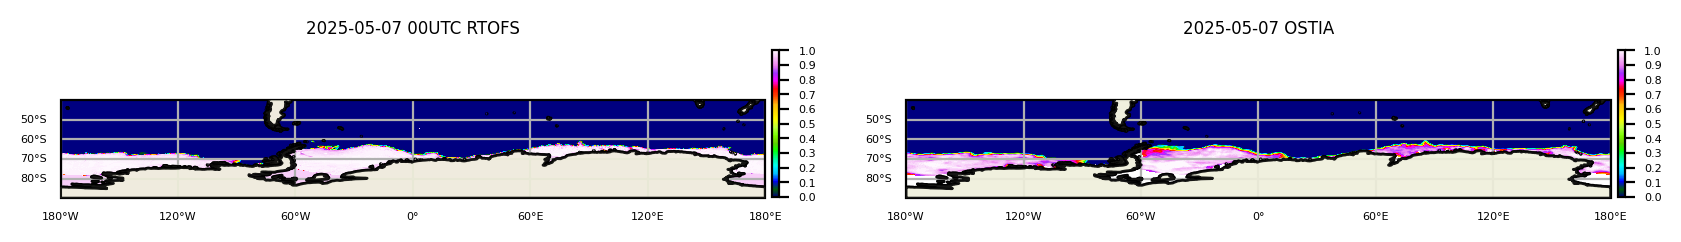

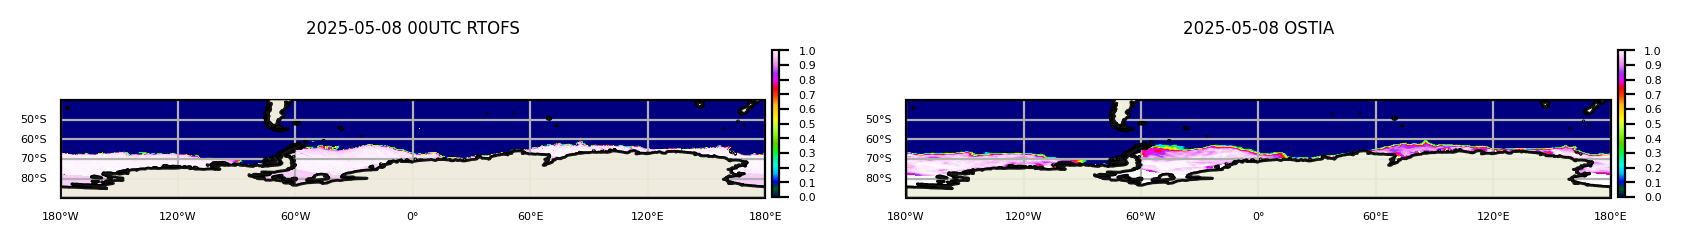

In [ ]:
data_dates = pd.date_range(start=date_bounds[0], end=date_bounds[1], freq='D')
for dd in data_dates:
  print("Plotting/comparing data for:\t", dd.strftime("%Y%m%d"))
  url = url_base + dd.strftime("%Y%m%d") + f"/{fName}"
  fName_save = "rtofs_"+ dd.strftime("%Y%m%d") + ".nc"
  #print(url, fName_save)
  !wget {url} -O {fName_save}

  ds_rtofs = xr.open_dataset(fName_save, decode_times=False)

  plot_date = dd.strftime("%Y-%m-%d")
  fig = plt.figure(figsize=[10,12], dpi=200)

  plot_subplot(fig, 1, ds_rtofs.ice_coverage, 'Longitude', 'Latitude', '{} 00UTC RTOFS'.format(plot_date), nPlots=2)
  plot_subplot(fig, 2, ds_ostia_ice.sel(time=plot_date).sea_ice_fraction, 'longitude', 'latitude', '{} OSTIA'.format(plot_date), nPlots=2)

  figName = plot_date + '_RTOFS_OSTIA.png'
  fig.savefig(figName, bbox_inches='tight')
  print(f'Saved... {figName}')

In [ ]:
#!wget https://noaa-nws-rtofs-pds.s3.amazonaws.com/rtofs.20250501/rtofs_glo_2ds_n000_ice.nc
#import xarray as xr
#ds = xr.open_dataset('rtofs_glo_2ds_n000_ice.nc')
#ds